Read in Data, fill NaN's with zeros, assess that correlation of the features

   Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0     26    92  2011-08-26      87235.57      False        61.10       3.796   
1     34    22  2011-03-25       5945.97      False        53.11       3.480   
2     21    28  2010-12-03       1219.89      False        50.43       2.708   
3      8     9  2010-09-17      11972.71      False        75.32       2.582   
4     19    55  2012-05-18       8271.82      False        58.81       4.029   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  136.213613   
1        NaN        NaN        NaN        NaN        NaN  128.616064   
2        NaN        NaN        NaN        NaN        NaN  211.265543   
3        NaN        NaN        NaN        NaN        NaN  214.878556   
4   12613.98        NaN       11.5    1705.28    3600.79  138.106581   

   Unemployment Type    Size  
0         7.767    A  152513  
1        10.398    A  15

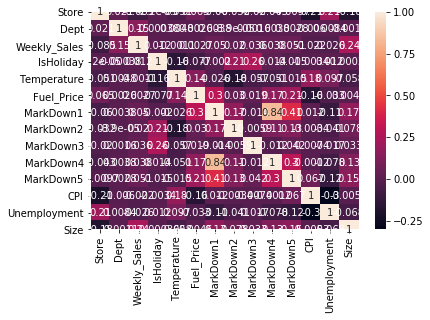

In [2]:
import pandas as pd
import seaborn as sns

df_train = pd.read_csv('Desktop/walmart data/course-material-walmart-challenge/train.csv')
print(df_train.head())
print(df_train.describe())

df_train = df_train.fillna(0)

corrMatrix = df_train.corr()
sns.heatmap(corrMatrix, annot=True)

Replace categorical data (Store #, Dept #, and Store Type) with dummy variables. Also add a new 'Month" column and use the Month from the date. 

In [4]:
TypeDummies = pd.get_dummies(df_train.Type, prefix = 'Type')
merged1 = pd.concat([df_train,TypeDummies],axis='columns')
# print(merged1.head())
StoreDummies = pd.get_dummies(merged1.Store, prefix = 'Store')
merged2 = pd.concat([merged1,StoreDummies],axis='columns')
# print(merged2.head())
DeptDummies = pd.get_dummies(merged2.Dept, prefix = 'Dept')
final = pd.concat([merged2,DeptDummies],axis='columns')
# print(final.head())
final['Month'] = final['Date'].str[5:7].astype(int)
final = final.drop(['Store','Type','Dept','Date'],axis='columns')

final.head()

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Month
0,87235.57,False,61.10,3.796,0.00,0.0,0.0,0.00,0.00,136.213613,...,0,1,0,0,0,0,0,0,0,8
1,5945.97,False,53.11,3.480,0.00,0.0,0.0,0.00,0.00,128.616064,...,0,0,0,0,0,0,0,0,0,3
2,1219.89,False,50.43,2.708,0.00,0.0,0.0,0.00,0.00,211.265543,...,0,0,0,0,0,0,0,0,0,12
3,11972.71,False,75.32,2.582,0.00,0.0,0.0,0.00,0.00,214.878556,...,0,0,0,0,0,0,0,0,0,9
4,8271.82,False,58.81,4.029,12613.98,0.0,11.5,1705.28,3600.79,138.106581,...,0,0,0,0,0,0,0,0,0,5


Seperate the independent from the dependent variables and creat a test/train split for model

In [6]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X = final.drop(['Weekly_Sales'],axis='columns')
y = final.Weekly_Sales

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30)

r^2: 0.9578549222983074
root mean squared error: 4682.128230176427
mean squared error: 21922324.763815034
CPU times: user 7min 46s, sys: 5.86 s, total: 7min 52s
Wall time: 3min 7s


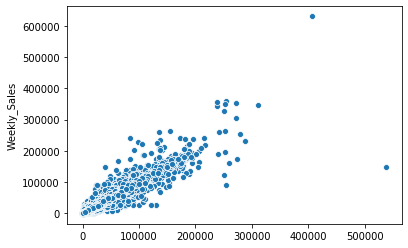

In [22]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

etr = ExtraTreesRegressor(n_estimators=30,n_jobs=-1) 
etr.fit(X_train,Y_train)
y_pred=etr.predict(X_test)

ax = sns.scatterplot(x=y_pred, y=Y_test)

print("r^2: "+ str(r2_score(Y_test,y_pred)))
print("root mean squared error: "+ str(np.sqrt((mean_squared_error(Y_test,y_pred)))))
print("mean squared error: "+str((mean_squared_error(Y_test,y_pred))))

create a KFold and perform a cross validation test. (changed this from kfold, to just 2 folds, becuase it was taking forever)

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# kfold = KFold(n_splits=2, random_state=1, shuffle=True)
scores = cross_val_score(etr, X, y, cv=2)
print('cv accuracy scores:'+ str(scores))
print('cv mean and SD :' +str(scores.mean()),scores.std())

cv accuracy scores:[0.93930265 0.95479966]
cv mean and SD :0.947051155963466 0.007748502309264549
[0.93930265 0.95479966]


look at feature importances, printed the top 15, I believe that these are already normalized. 

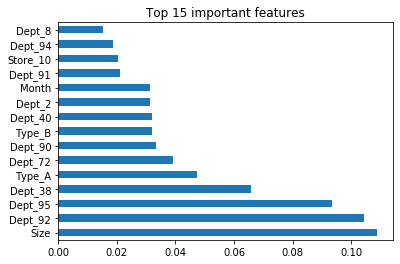

In [23]:
feat_importances = pd.Series(etr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()


look at the relationship between the most important feaures and weekly sales. it looks like Size and Type_A are heaveily correlated, so I could possibly drop Type_A.

In [20]:
sizeTypedf = final[['Size','Dept_92','Dept_95','Dept_38','Type_A','Weekly_Sales']].copy()
sizeTypedf.corr()

,Size,Dept_92,Dept_95,Dept_38,Type_A,Weekly_Sales
Size,1.000000,-0.014470,-0.013287,-0.012446,0.762445,0.243935
Dept_92,-0.014470,1.000000,-0.015397,-0.015422,-0.005507,0.321766
Dept_95,-0.013287,-0.015397,1.000000,-0.015554,-0.006665,0.296369
Dept_38,-0.012446,-0.015422,-0.015554,1.000000,-0.004820,0.249108
Type_A,0.762445,-0.005507,-0.006665,-0.004820,1.000000,0.185057
Weekly_Sales,0.243935,0.321766,0.296369,0.249108,0.185057,1.000000
